In [2]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed, df_utils
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [40]:
# data loading
df = pd.read_csv('dataset/ER_Europe_subset_10nodes.csv')
display(df.head())
display(df.tail())

df['ds'] = pd.to_datetime(df['ds'])
df['ID'] = df['ID'].astype(str)
IDs = df['ID'].unique()
# print(IDs)

df = df[df["ds"] > "2013-12-31"]

# plot dataset
fig = px.line(df[(df['ds'] > "2014-12-01") & (df['ds'] <= "2014-12-31")], x='ds', y='y', color='ID')
fig.update_layout(title='European Engergy Consumption Data', xaxis_title='Date', yaxis_title='Energy consumption', legend_title='ID', width=800, height=600)
fig.show()

,ds,ID,y,solar,solar_fcs
0,2012-01-01 00:00:00,1,75.6549,0.0,0.0
1,2012-01-01 01:00:00,1,70.9958,0.0,0.0
2,2012-01-01 02:00:00,1,66.6382,0.0,0.0
3,2012-01-01 03:00:00,1,62.9920,0.0,0.0
4,2012-01-01 04:00:00,1,61.0699,0.0,0.0


,ds,ID,y,solar,solar_fcs
131515,2014-12-31 19:00:00,5,113.4987,0.0,0.0
131516,2014-12-31 20:00:00,5,109.3758,0.0,0.0
131517,2014-12-31 21:00:00,5,99.1238,0.0,0.0
131518,2014-12-31 22:00:00,5,94.0057,0.0,0.0
131519,2014-12-31 23:00:00,5,91.1465,0.0,0.0


In [41]:
# data preperation
# df = df.drop(columns=['solar', 'solar_fcs']) # comment out if to use lagged and future regressors
# set conditional seasonalities
df = df_utils.add_quarter_condition(df) # add four seasons
quarters = ["summer", "fall", "winter", "spring"]
# add weekday and weekend for each season
for quarter in quarters:
    df[f'{quarter}_weekday'] = 0
    df.loc[(df[quarter] == 1) & (df["ds"].dt.weekday < 5), f'{quarter}_weekday'] = 1
    df[f'{quarter}_weekend'] = 0
    df.loc[(df[quarter] == 1) & (df["ds"].dt.weekday >= 5), f'{quarter}_weekend'] = 1
df.head(5)

,ds,ID,y,solar,solar_fcs,summer,winter,spring,fall,summer_weekday,summer_weekend,fall_weekday,fall_weekend,winter_weekday,winter_weekend,spring_weekday,spring_weekend
17521,2013-12-31 01:00:00,1,68.6445,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
17522,2013-12-31 02:00:00,1,64.4657,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
17523,2013-12-31 03:00:00,1,62.3702,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
17524,2013-12-31 04:00:00,1,62.5002,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
17525,2013-12-31 05:00:00,1,65.0789,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer

Train shape: (32185, 17), Validation shape: (4345, 17), Calibration shape: (4735, 17), Test shape: (5170, 17)


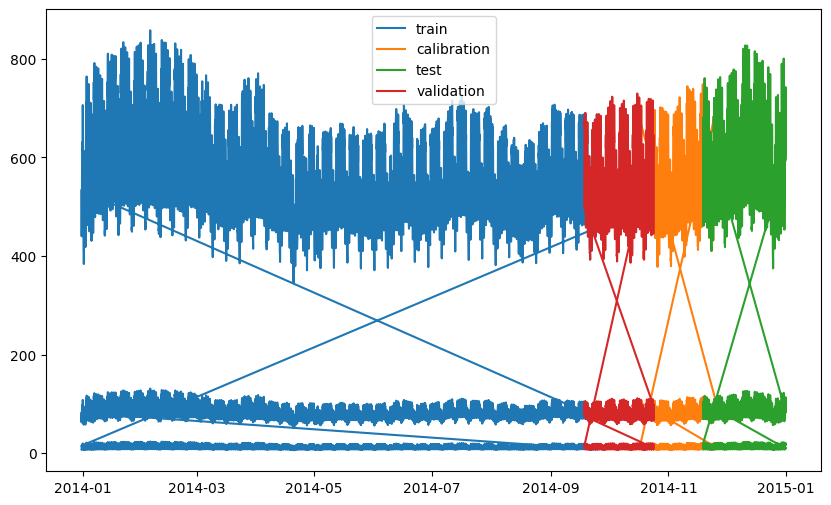

In [42]:
# model setup
set_random_seed(42)
confidence_lv = 0.9
quantile_list = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)] # 0.05 and 0.95 quantiles
n_lags = 7 * 24 # predict next value based on last 7 days
n_forecasts = 7 # predict 24 hours ahead
n_changepoints = 20 # trend change points
epochs = 50
trainer_config = {"accelerator":"gpu"}

model = NeuralProphet(
    n_lags=n_lags,
    n_forecasts= n_forecasts,
    n_changepoints= n_changepoints,
    learning_rate= 0.01,
    ar_layers= [32, 16, 16, 32],
    yearly_seasonality= True,
    weekly_seasonality= False,
    daily_seasonality= False,
    epochs= epochs,
    batch_size= 1024,
    quantiles= quantile_list,
    trainer_config= trainer_config
)
model.set_plotting_backend("plotly-static")

# add regressors
model.add_lagged_regressor(names="solar", n_lags=10 * 24) # 10 days as lagged regressor
model.add_future_regressor(name="solar_fcs")

# add conditional seasonalities to the model
for quarter in quarters:
    model.add_seasonality(name=f"{quarter}_weekly", period=7, fourier_order=14, condition_name=f"{quarter}")
    model.add_seasonality(name=f"{quarter}_weekday", period=1, fourier_order=6, condition_name=f"{quarter}_weekday")
    model.add_seasonality(name=f"{quarter}_weekend", period=1, fourier_order=6, condition_name=f"{quarter}_weekend")

# split data
df_train, df_test = model.split_df(df, valid_p=0.1, local_split=True)
df_train, df_cal = model.split_df(df_train, valid_p=0.1, local_split=True)
df_train, df_val = model.split_df(df_train, valid_p=0.1, local_split=True)
print(f"Train shape: {df_train.shape}, Validation shape: {df_val.shape}, Calibration shape: {df_cal.shape}, Test shape: {df_test.shape}")

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df_train.ds, df_train.y, label="train")
ax.plot(df_cal.ds, df_cal.y, label="calibration")
ax.plot(df_test.ds, df_test.y, label="test")
ax.plot(df_val.ds, df_val.y, label="validation")
ax.legend()
plt.show()


In [43]:
# model training
metrics = model.fit(df_train, validation_df=df_val, freq="H", progress=True, metrics=True)
print(metrics.iloc[-1][["Loss", "Loss_val"]]) # print the loss values

# plot Loss_val and Loss_train per epoch - uncomment if predicting more than 1 future point
fig = go.Figure()
fig.add_trace(go.Scatter(x=metrics.index, y=metrics["Loss"], mode='lines', name='Loss_train'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics["Loss_val"], mode='lines', name='Loss_val'))
fig.update_layout(title='Loss and Loss_val per epoch', xaxis_title='Epoch', yaxis_title='Loss', width=800, height=600)
fig.show()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined 

Epoch 50: 100%|██████████| 50/50 [00:03<00:00, 12.74it/s, loss=0.00325, v_num=44, MAE_val=0.0407, RMSE_val=0.0515, Loss_val=0.0533, RegLoss_val=0.000, MAE=0.0296, RMSE=0.0398, Loss=0.00328, RegLoss=0.000]   
Loss        0.003278
Loss_val    0.053263
Name: 49, dtype: float64


In [44]:
# Conformalized Quantile Regression (CQR) model

# parameters
method = "naive" # conformalized quantile regression
alpha = 1 - confidence_lv # significance level
model_cqr = model.conformal_predict(df_test, calibration_df=df_cal, method=method, alpha=alpha, plotting_backend="plotly-static")

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.894% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.894% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.895% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Dropped 7 rows at the end with NaNs in future regressors.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresp

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.903% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.903% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.903% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.903% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.903% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.904%

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.13it/s]


yhat1                           yhat2                   \
  interval_width miscoverage_rate interval_width miscoverage_rate   
0     483.484131         0.010928            NaN         0.010165   

           yhat3                           yhat4                   \
  interval_width miscoverage_rate interval_width miscoverage_rate   
0            NaN         0.024905            NaN          0.07751   

           yhat5                           yhat6                   \
  interval_width miscoverage_rate interval_width miscoverage_rate   
0            NaN         0.017789            NaN         0.029225   

           yhat7                   
  interval_width miscoverage_rate  
0            NaN         0.026175

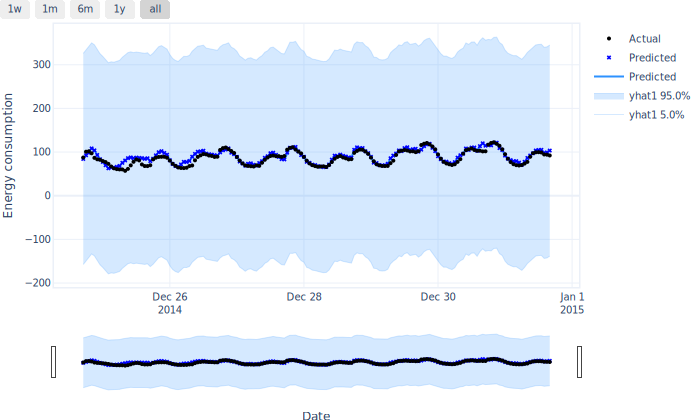

In [45]:
# evaluate the model

cqr_metrics = uncertainty_evaluate(model_cqr)
display(cqr_metrics)
# plot the forecast with uncertainty intervals
cutoff = 24 * 7 # plot 1 week in the future
fig = model.highlight_nth_step_ahead_of_each_forecast(1).plot(
    model_cqr[-cutoff:], plotting_backend="plotly-static", xlabel="Date", ylabel="Energy consumption")
